# Sheet Music Matching with Optimization

## Project Goal
Learn optimal feature weights to match sheet music pages using constrained optimization techniques.

## Approach
- **Dataset**: Start with music21's built-in Bach chorales as our test corpus
- **Method**: Weighted similarity learning with convex optimization
- **Tools**: Use cvxpy for constrained optimization to learn feature weights that maximize matching accuracy

## Key Components
1. Extract musical features from sheet music (pitch, rhythm, harmony)
2. Define a weighted similarity function
3. Use optimization to learn weights that best distinguish matching vs. non-matching pages
4. Validate performance on held-out test set

## Setup: Install and Import Libraries

In [1]:
# Install required packages
%pip install music21 numpy pandas matplotlib seaborn scipy cvxpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import music21 as m21
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import cvxpy as cp

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("All libraries imported successfully!")
print(f"music21 version: {m21.VERSION_STR}")

All libraries imported successfully!
music21 version: 9.9.1


## Verify Access to Bach Chorale Corpus

Check that we can access music21's built-in corpus of Bach chorales, which we'll use for developing and testing our optimization-based matching algorithm.

In [3]:
# List available Bach chorales in the music21 corpus
bach_chorales = m21.corpus.search('bach', 'composer')

print(f"Total Bach chorales available: {len(bach_chorales)}")
print("\nFirst 10 chorales:")
for i, chorale in enumerate(bach_chorales[:10], 1):
    print(f"{i}. {chorale.metadata.title if chorale.metadata else 'Untitled'} - {chorale.sourcePath}")

# Load a sample chorale to verify everything works
print("\n" + "="*60)
print("Loading a sample chorale to verify corpus access...")
sample_chorale = m21.corpus.parse('bach/bwv66.6')
print(f"✓ Successfully loaded: {sample_chorale.metadata.title}")
print(f"  - Parts: {len(sample_chorale.parts)}")
print(f"  - Measures: {len(sample_chorale.parts[0].getElementsByClass('Measure'))}")
print(f"  - Key: {sample_chorale.analyze('key')}")

Total Bach chorales available: 363

First 10 chorales:
1. None - bach/bwv10.7.mxl
2. None - bach/bwv101.7.mxl
3. None - bach/bwv102.7.mxl
4. None - bach/bwv103.6.mxl
5. None - bach/bwv104.6.mxl
6. None - bach/bwv108.6.mxl
7. None - bach/bwv11.6.mxl
8. None - bach/bwv110.7.mxl
9. None - bach/bwv112.5-sc.mxl
10. None - bach/bwv113.8.mxl

Loading a sample chorale to verify corpus access...
✓ Successfully loaded: None
  - Parts: 4
  - Measures: 10
  - Key: f# minor


## Data Selection and Preparation

Select a subset of Bach chorales and split them into "pages" (chunks of 8 consecutive measures) for our matching experiment.

In [4]:
# Configuration
TARGET_PIECES_PER_COMPOSER = 6  # Try to get 5-6 pieces per composer
MEASURES_PER_PAGE = 8
TARGET_PAGES_PER_PIECE = 4
TARGET_MEASURES = MEASURES_PER_PAGE * TARGET_PAGES_PER_PIECE  # 32 measures

# Define composers to include
COMPOSERS = {
    'bach': {
        'name': 'Bach',
        'search_term': 'bach',
        'target_pieces': 6,
        'era': 'Baroque'
    },
    'mozart': {
        'name': 'Mozart',
        'search_term': 'mozart',
        'target_pieces': 6,
        'era': 'Classical'
    },
    'beethoven': {
        'name': 'Beethoven',
        'search_term': 'beethoven',
        'target_pieces': 6,
        'era': 'Classical/Romantic'
    }
}

print("Multi-Composer Data Selection")
print("=" * 80)
print(f"Configuration:")
print(f"  • Composers: {len(COMPOSERS)} (Bach, Mozart, Beethoven)")
print(f"  • Target pieces per composer: {TARGET_PIECES_PER_COMPOSER}")
print(f"  • Minimum measures per piece: {TARGET_MEASURES}")
print(f"  • Pages per piece: {TARGET_PAGES_PER_PIECE}")
print(f"  • Total expected pieces: {len(COMPOSERS) * TARGET_PIECES_PER_COMPOSER}")
print()

# Store all pieces data
pieces_data = {}
composer_summary = {}

for composer_id, composer_info in COMPOSERS.items():
    print(f"\n{'=' * 80}")
    print(f"Processing {composer_info['name']} ({composer_info['era']})")
    print(f"{'=' * 80}")
    
    # Search for pieces by this composer
    try:
        search_results = m21.corpus.search(composer_info['search_term'], 'composer')
        print(f"Found {len(search_results)} pieces in corpus")
    except Exception as e:
        print(f"✗ Error searching for {composer_info['name']}: {e}")
        composer_summary[composer_id] = {'pieces': 0, 'skipped': 0, 'errors': []}
        continue
    
    # Filter pieces that meet our criteria
    eligible_pieces = []
    skipped_pieces = []
    
    for result in search_results:
        try:
            # Load the score
            score = m21.corpus.parse(result.sourcePath)
            
            # Get first part and count measures
            if len(score.parts) > 0:
                measures = score.parts[0].getElementsByClass(m21.stream.Measure)
                num_measures = len(measures)
                
                if num_measures >= TARGET_MEASURES:
                    # Extract metadata
                    title = score.metadata.title if score.metadata and score.metadata.title else "Unknown"
                    
                    # Create piece_id from path
                    path_name = result.sourcePath.name if hasattr(result.sourcePath, 'name') else str(result.sourcePath).split('/')[-1]
                    # Remove file extension
                    piece_id = path_name.replace('.xml', '').replace('.mxl', '').replace('.krn', '').replace('.mid', '')
                    
                    eligible_pieces.append({
                        'piece_id': piece_id,
                        'path': result.sourcePath,
                        'score': score,
                        'num_measures': num_measures,
                        'title': title,
                        'composer': composer_id
                    })
                else:
                    skipped_pieces.append({'reason': 'too_few_measures', 'measures': num_measures})
                    
        except Exception as e:
            skipped_pieces.append({'reason': 'parse_error', 'error': str(e)})
    
    print(f"  • Eligible pieces: {len(eligible_pieces)}")
    print(f"  • Skipped pieces: {len(skipped_pieces)}")
    
    # Select target number of pieces
    selected_count = min(composer_info['target_pieces'], len(eligible_pieces))
    selected_pieces = eligible_pieces[:selected_count]
    
    if selected_count < 4:
        print(f"  ⚠ WARNING: Only found {selected_count} pieces (minimum 4 recommended)")
    
    # Load and process selected pieces
    print(f"\n  Loading {selected_count} pieces:")
    
    for piece_info in selected_pieces:
        piece_id = f"{composer_id}_{piece_info['piece_id']}"
        score = piece_info['score']
        
        # Extract metadata
        title = piece_info['title']
        
        # Get key (handle potential errors)
        try:
            key = score.analyze('key')
        except:
            key = "Unknown"
        
        # Get time signature from first part
        time_sig = None
        for ts in score.flat.getElementsByClass(m21.meter.TimeSignature):
            time_sig = ts
            break
        time_sig_str = str(time_sig) if time_sig else "Unknown"
        
        # Count measures
        measures = score.parts[0].getElementsByClass(m21.stream.Measure)
        num_measures = len(measures)
        
        # Store the data
        pieces_data[piece_id] = {
            'score': score,
            'title': title,
            'key': str(key),
            'time_signature': time_sig_str,
            'num_measures': num_measures,
            'composer': composer_id
        }
        
        # Print metadata
        print(f"    ✓ {piece_id}")
        print(f"      Title: {title[:50]}{'...' if len(title) > 50 else ''}")
        print(f"      Measures: {num_measures}, Key: {key}, Time: {time_sig_str}")
    
    # Store summary
    composer_summary[composer_id] = {
        'pieces': selected_count,
        'skipped': len(skipped_pieces),
        'eligible': len(eligible_pieces)
    }

print("\n" + "=" * 80)
print("Summary: Pieces Loaded by Composer")
print("=" * 80)
for composer_id, summary in composer_summary.items():
    composer_name = COMPOSERS[composer_id]['name']
    print(f"{composer_name:12s}: {summary['pieces']} pieces selected (from {summary['eligible']} eligible, {summary['skipped']} skipped)")

print(f"\nTotal pieces loaded: {len(pieces_data)}")
print(f"Expected pages: {len(pieces_data) * TARGET_PAGES_PER_PIECE}")


Multi-Composer Data Selection
Configuration:
  • Composers: 3 (Bach, Mozart, Beethoven)
  • Target pieces per composer: 6
  • Minimum measures per piece: 32
  • Pages per piece: 4
  • Total expected pieces: 18


Processing Bach (Baroque)
Found 363 pieces in corpus
  • Eligible pieces: 16
  • Skipped pieces: 347

  Loading 6 pieces:
    ✓ bach_bwv17.7
      Title: Unknown
      Measures: 42, Key: A major, Time: <music21.meter.TimeSignature 3/4>
    ✓ bach_bwv248.42-4
      Title: Unknown
      Measures: 53, Key: F major, Time: <music21.meter.TimeSignature 3/4>
    ✓ bach_bwv276
      Title: Unknown
      Measures: 32, Key: d minor, Time: <music21.meter.TimeSignature 4/4>
    ✓ bach_bwv29.8
      Title: Unknown
      Measures: 41, Key: D major, Time: <music21.meter.TimeSignature 3/4>
    ✓ bach_bwv320
      Title: Unknown
      Measures: 38, Key: F major, Time: <music21.meter.TimeSignature 3/4>
    ✓ bach_bwv328
      Title: Unknown
      Measures: 57, Key: C major, Time: <music21.meter.

/Users/ethanfan/Documents/Penn/stat4830/.venv/lib/python3.13/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Found 11 pieces in corpus
  • Eligible pieces: 10
  • Skipped pieces: 1

  Loading 6 pieces:
    ✓ mozart_movement1
      Title: Unknown
      Measures: 119, Key: D major, Time: <music21.meter.TimeSignature 4/4>
    ✓ mozart_movement2
      Title: Unknown
      Measures: 50, Key: A major, Time: <music21.meter.TimeSignature 3/4>
    ✓ mozart_movement3
      Title: Unknown
      Measures: 103, Key: D major, Time: <music21.meter.TimeSignature 2/4>
    ✓ mozart_movement1
      Title: Unknown
      Measures: 180, Key: G major, Time: <music21.meter.TimeSignature 3/8>
    ✓ mozart_movement2
      Title: Unknown
      Measures: 37, Key: e minor, Time: <music21.meter.TimeSignature 4/4>
    ✓ mozart_movement3
      Title: Unknown
      Measures: 62, Key: G major, Time: <music21.meter.TimeSignature 3/4>

Processing Beethoven (Classical/Romantic)
Found 23 pieces in corpus
  • Eligible pieces: 23
  • Skipped pieces: 0

  Loading 6 pieces:
    ✓ beethoven_opus132
      Title: Unknown
      Measures:

### Split Pieces into Pages

Define a "page" as 8 consecutive measures. Split each piece into pages for the matching experiment.
Each piece produces exactly 4 pages (measures 0-7, 8-15, 16-23, 24-31).

In [5]:
# Create pages from pieces - STRICT MODE
# Each piece MUST produce exactly 4 pages of 8 measures each
pages_list = []

print("Creating pages from pieces (STRICT MODE):")
print("=" * 80)
print(f"Configuration: {MEASURES_PER_PAGE} measures/page, {TARGET_PAGES_PER_PIECE} pages/piece")
print()

for piece_id, data in pieces_data.items():
    score = data['score']
    num_measures = data['num_measures']
    composer = data['composer']
    
    # Use first part as reference for splitting
    part = score.parts[0]
    measures = list(part.getElementsByClass(m21.stream.Measure))
    
    print(f"{piece_id}: {num_measures} measures (composer: {composer})", end="")
    
    # Verify we have enough measures (should always be true due to filtering)
    if num_measures < TARGET_MEASURES:
        print(f" ✗ SKIPPED (need {TARGET_MEASURES})")
        continue
    
    print(f" → Creating {TARGET_PAGES_PER_PIECE} pages")
    
    # Create exactly 4 pages, using only the first 32 measures
    for page_idx in range(TARGET_PAGES_PER_PIECE):
        start_idx = page_idx * MEASURES_PER_PAGE
        end_idx = start_idx + MEASURES_PER_PAGE
        
        # Extract exactly 8 consecutive measures
        page_measures = measures[start_idx:end_idx]
        
        # Verify we got exactly 8 measures
        if len(page_measures) != MEASURES_PER_PAGE:
            print(f"  ✗ Page {page_idx}: ERROR - got {len(page_measures)} measures instead of {MEASURES_PER_PAGE}")
            continue
        
        # Get measure numbers (they might not start at 1)
        measure_numbers = [m.number for m in page_measures]
        start_measure_num = measure_numbers[0]
        end_measure_num = measure_numbers[-1]
        
        # Create page data with new naming convention
        page_data = {
            'page_id': f"{piece_id}_page{page_idx}",  # e.g., "bach_bwv276_page0"
            'piece_id': piece_id,  # e.g., "bach_bwv276"
            'composer': composer,  # e.g., "bach"
            'page_index': page_idx,
            'measures': page_measures,  # Store actual measure objects
            'start_measure': start_measure_num,
            'end_measure': end_measure_num,
            'num_measures': len(page_measures)
        }
        
        pages_list.append(page_data)
        print(f"  ✓ Page {page_idx}: measures {start_measure_num}-{end_measure_num} (indices {start_idx}-{end_idx-1})")

print("\n" + "=" * 80)
print(f"Successfully created {len(pages_list)} pages from {len(pieces_data)} pieces")
print(f"Expected: {len(pieces_data) * TARGET_PAGES_PER_PIECE} pages")
print(f"Status: {'✓ SUCCESS' if len(pages_list) == len(pieces_data) * TARGET_PAGES_PER_PIECE else '✗ MISMATCH'}")

# Verify each piece produced exactly 4 pages
print("\nVerification - Pages per Piece:")
for piece_id in pieces_data.keys():
    count = sum(1 for p in pages_list if p['piece_id'] == piece_id)
    status = "✓" if count == TARGET_PAGES_PER_PIECE else "✗"
    print(f"  {status} {piece_id}: {count} pages")

# Summary by composer
print("\nPages by Composer:")
for composer_id in COMPOSERS.keys():
    count = sum(1 for p in pages_list if p['composer'] == composer_id)
    pieces = sum(1 for piece_id in pieces_data.keys() if pieces_data[piece_id]['composer'] == composer_id)
    print(f"  {COMPOSERS[composer_id]['name']:12s}: {count} pages from {pieces} pieces")


Creating pages from pieces (STRICT MODE):
Configuration: 8 measures/page, 4 pages/piece

bach_bwv17.7: 42 measures (composer: bach) → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-14 (indices 8-15)
  ✓ Page 2: measures 15-21 (indices 16-23)
  ✓ Page 3: measures 22-28 (indices 24-31)
bach_bwv248.42-4: 53 measures (composer: bach) → Creating 4 pages
  ✓ Page 0: measures 1-8 (indices 0-7)
  ✓ Page 1: measures 9-16 (indices 8-15)
  ✓ Page 2: measures 17-24 (indices 16-23)
  ✓ Page 3: measures 25-32 (indices 24-31)
bach_bwv276: 32 measures (composer: bach) → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-15 (indices 8-15)
  ✓ Page 2: measures 16-23 (indices 16-23)
  ✓ Page 3: measures 24-30 (indices 24-31)
bach_bwv29.8: 41 measures (composer: bach) → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-14 (indices 8-15)
  ✓ Page 2: measures 15-21 (indices 16-23)
  ✓ Page 3: measures 22-28 (indices 24-

### Create DataFrame for Pages

Store all page data in a pandas DataFrame for easy access and manipulation.

In [6]:
# Create DataFrame with page data
# Note: We'll store measure objects separately to avoid serialization issues
pages_df = pd.DataFrame([
    {
        'page_id': p['page_id'],
        'piece_id': p['piece_id'],
        'composer': p['composer'],
        'page_index': p['page_index'],
        'start_measure': p['start_measure'],
        'end_measure': p['end_measure'],
        'num_measures': p['num_measures']
    }
    for p in pages_list
])

# Store measure objects in a separate dictionary for easy lookup
pages_measures = {p['page_id']: p['measures'] for p in pages_list}

print("Pages DataFrame:")
print("=" * 80)
print(pages_df)
print("\n" + "=" * 80)

print(f"Shape: {pages_df.shape[0]} pages × {pages_df.shape[1]} columns")

print(f"\nComposer distribution:")
for composer_id in sorted(pages_df['composer'].unique()):
    count = (pages_df['composer'] == composer_id).sum()
    print(f"  {COMPOSERS[composer_id]['name']:12s}: {count} pages")

Pages DataFrame:
                      page_id             piece_id   composer  page_index  \
0          bach_bwv17.7_page0         bach_bwv17.7       bach           0   
1          bach_bwv17.7_page1         bach_bwv17.7       bach           1   
2          bach_bwv17.7_page2         bach_bwv17.7       bach           2   
3          bach_bwv17.7_page3         bach_bwv17.7       bach           3   
4      bach_bwv248.42-4_page0     bach_bwv248.42-4       bach           0   
5      bach_bwv248.42-4_page1     bach_bwv248.42-4       bach           1   
6      bach_bwv248.42-4_page2     bach_bwv248.42-4       bach           2   
7      bach_bwv248.42-4_page3     bach_bwv248.42-4       bach           3   
8           bach_bwv276_page0          bach_bwv276       bach           0   
9           bach_bwv276_page1          bach_bwv276       bach           1   
10          bach_bwv276_page2          bach_bwv276       bach           2   
11          bach_bwv276_page3          bach_bwv276       ba

### Summary Visualization

Display a summary table showing how many pages each piece produced, grouped by composer.

Summary: Pages per Piece
 Composer            Piece ID                                  Title  Total Measures  Pages Created  Measures Used
     Bach        bach_bwv17.7                                Unknown              42              4             32
     Bach    bach_bwv248.42-4                                Unknown              53              4             32
     Bach         bach_bwv276                                Unknown              32              4             32
     Bach        bach_bwv29.8                                Unknown              41              4             32
     Bach         bach_bwv320                                Unknown              38              4             32
     Bach         bach_bwv328                                Unknown              57              4             32
   Mozart    mozart_movement1                                Unknown             180              4             32
   Mozart    mozart_movement2                          

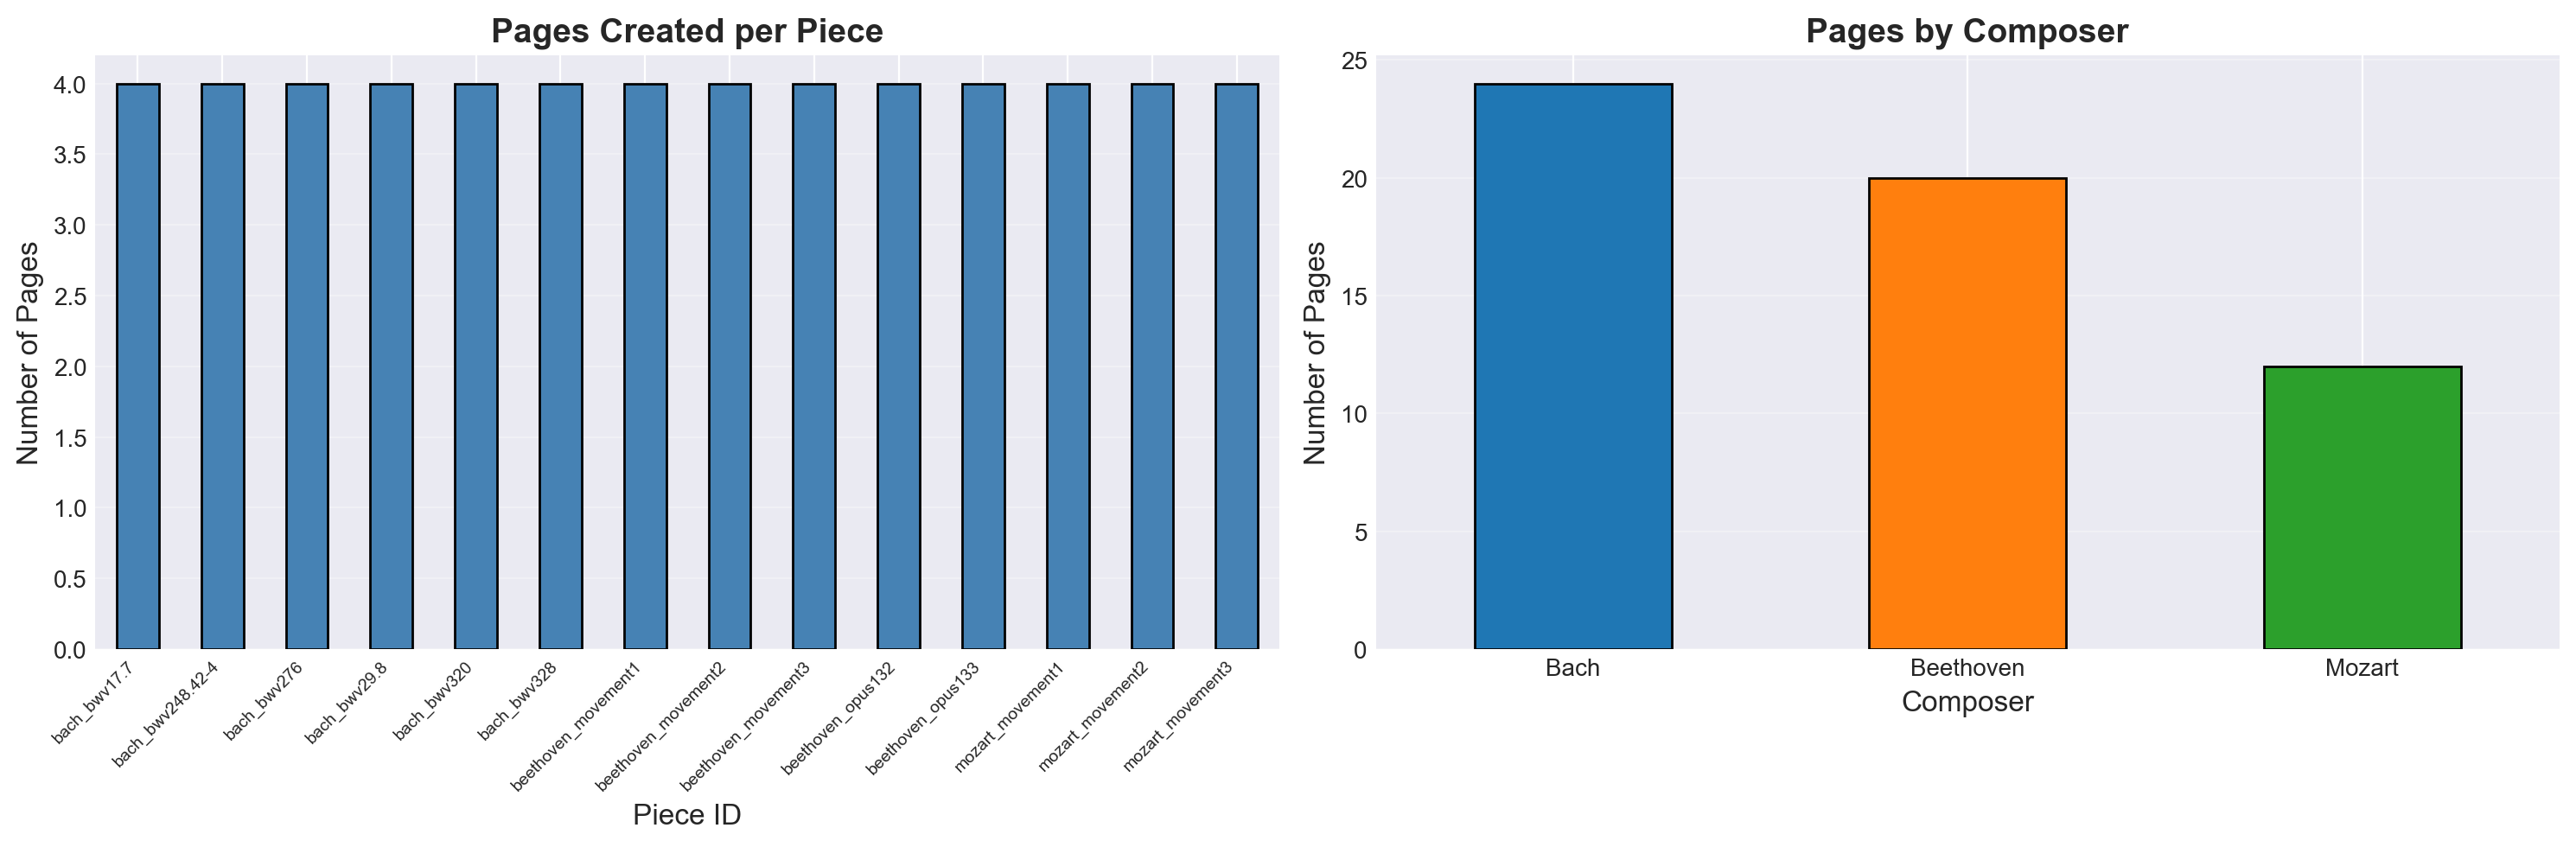


✓ Data preparation complete!


In [7]:
# Create summary statistics
summary_data = []

for piece_id in pieces_data.keys():
    num_pages = len(pages_df[pages_df['piece_id'] == piece_id])
    num_measures = pieces_data[piece_id]['num_measures']
    title = pieces_data[piece_id]['title']
    composer = pieces_data[piece_id]['composer']
    
    summary_data.append({
        'Composer': COMPOSERS[composer]['name'],
        'Piece ID': piece_id,
        'Title': title[:35] + '...' if len(title) > 35 else title,
        'Total Measures': num_measures,
        'Pages Created': num_pages,
        'Measures Used': num_pages * MEASURES_PER_PAGE
    })

summary_df = pd.DataFrame(summary_data)

print("Summary: Pages per Piece")
print("=" * 80)
print(summary_df.to_string(index=False))
print("\n" + "=" * 80)
print(f"Total Pages: {pages_df.shape[0]}")
print(f"Total Pieces: {len(pieces_data)}")
print(f"Average Pages per Piece: {pages_df.shape[0] / len(pieces_data):.1f}")

# Visualize distribution by composer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Pages per piece (all pieces)
pages_per_piece = pages_df['piece_id'].value_counts().sort_index()
pages_per_piece.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Piece ID', fontsize=12)
ax1.set_ylabel('Number of Pages', fontsize=12)
ax1.set_title('Pages Created per Piece', fontsize=14, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Pages by composer
composer_counts = pages_df['composer'].value_counts()
composer_names = [COMPOSERS[c]['name'] for c in composer_counts.index]
composer_counts.index = composer_names
composer_counts.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
ax2.set_xlabel('Composer', fontsize=12)
ax2.set_ylabel('Number of Pages', fontsize=12)
ax2.set_title('Pages by Composer', fontsize=14, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Data preparation complete!")

## Feature Extraction

Extract 5 musical features from each page for use in the optimization-based matching algorithm:

1. **key_numeric**: Key signature encoded as integer (0-11.5)
2. **time_signature_ratio**: Time signature as decimal (e.g., 3/4 = 0.75)
3. **average_pitch**: Mean MIDI pitch number from soprano voice
4. **pitch_range**: Range of pitches (max - min)
5. **note_density**: Notes per beat (rhythmic activity measure)

In [10]:
def extract_features_from_page(page_id, measures):
    """
    Extract 5 musical features from a page (chunk of measures).
    
    Args:
        page_id: Unique identifier for the page
        measures: List of music21 Measure objects
        
    Returns:
        Dictionary with extracted features
    """
    features = {
        'page_id': page_id,
        'key_numeric': 0.0,
        'time_signature_ratio': 1.0,
        'average_pitch': 0.0,
        'pitch_range': 0.0,
        'note_density': 0.0
    }
    
    try:
        # Reconstruct a stream from the measures for analysis
        page_stream = m21.stream.Part()
        for measure in measures:
            page_stream.append(measure)
        
        # ===== Feature 1: key_numeric =====
        try:
            key = page_stream.analyze('key')
            # Map pitch class: C=0, C#=1, D=2, ..., B=11
            tonic = key.tonic
            pitch_class = tonic.pitchClass  # 0-11
            # Add 0.5 for minor keys
            mode_offset = 0.0 if key.mode == 'major' else 0.5
            features['key_numeric'] = pitch_class + mode_offset
        except Exception as e:
            # Default to 0 (C major) if analysis fails
            features['key_numeric'] = 0.0
            print(f"⚠ Warning: Key analysis failed for {page_id}: {e}")
        
        # ===== Feature 2: time_signature_ratio =====
        try:
            time_sigs = page_stream.flatten().getElementsByClass(m21.meter.TimeSignature)
            if time_sigs:
                ts = time_sigs[0]  # Use first time signature
                # Convert to ratio (e.g., 3/4 = 0.75, 4/4 = 1.0)
                features['time_signature_ratio'] = ts.numerator / ts.denominator
            else:
                # Default to 4/4
                features['time_signature_ratio'] = 1.0
        except Exception as e:
            features['time_signature_ratio'] = 1.0
            print(f"⚠ Warning: Time signature extraction failed for {page_id}: {e}")
        
        # ===== Features 3-5: pitch and rhythm features =====
        # Extract notes from the top voice (soprano in chorales)
        try:
            # Get all notes from the page (flatten to include all voices, or use first part)
            notes = page_stream.flatten().notes  # This gets all Note and Chord objects
            
            # Extract MIDI pitch numbers
            midi_pitches = []
            note_count = 0
            
            for element in notes:
                if isinstance(element, m21.note.Note):
                    midi_pitches.append(element.pitch.midi)
                    note_count += 1
                elif isinstance(element, m21.chord.Chord):
                    # For chords, use the highest note (soprano)
                    midi_pitches.append(max(p.midi for p in element.pitches))
                    note_count += 1
            
            # Feature 3: average_pitch
            if midi_pitches:
                features['average_pitch'] = np.mean(midi_pitches)
            else:
                features['average_pitch'] = 0.0
                print(f"⚠ Warning: No notes found in {page_id}")
            
            # Feature 4: pitch_range
            if midi_pitches:
                features['pitch_range'] = max(midi_pitches) - min(midi_pitches)
            else:
                features['pitch_range'] = 0.0
            
            # Feature 5: note_density (notes per beat)
            # Calculate total duration in quarter notes
            total_duration = sum(measure.duration.quarterLength for measure in measures)
            
            if total_duration > 0 and note_count > 0:
                features['note_density'] = note_count / total_duration
            else:
                features['note_density'] = 0.0
                if total_duration == 0:
                    print(f"⚠ Warning: Total duration is 0 for {page_id}")
                    
        except Exception as e:
            print(f"⚠ Warning: Pitch/rhythm feature extraction failed for {page_id}: {e}")
            features['average_pitch'] = 0.0
            features['pitch_range'] = 0.0
            features['note_density'] = 0.0
    
    except Exception as e:
        print(f"✗ Error processing {page_id}: {e}")
    
    return features

print("✓ Feature extraction function defined")

✓ Feature extraction function defined


### Extract Features from All Pages

Apply the feature extraction function to all pages in the dataset.

In [11]:
print("Extracting features from all pages...")
print("=" * 80)

# Extract features for each page
features_list = []

for page_data in pages_list:
    page_id = page_data['page_id']
    measures = page_data['measures']
    
    # Extract features
    features = extract_features_from_page(page_id, measures)
    
    # Add piece_id and composer for grouping
    features['piece_id'] = page_data['piece_id']
    features['composer'] = page_data['composer']
    
    features_list.append(features)

# Create DataFrame with features
features_df = pd.DataFrame(features_list)

# Reorder columns for better readability
column_order = ['page_id', 'piece_id', 'composer', 'key_numeric', 'time_signature_ratio', 
                'average_pitch', 'pitch_range', 'note_density']
features_df = features_df[column_order]

print("\n" + "=" * 80)
print(f"✓ Successfully extracted features from {len(features_df)} pages")
print("\nFeatures DataFrame:")
print(features_df.to_string())


Extracting features from all pages...
⚠ Warning: Key analysis failed for bach_bwv29.8_page2: failed to get likely keys for Stream component
⚠ Warning: No notes found in bach_bwv29.8_page2
⚠ Warning: Key analysis failed for bach_bwv29.8_page3: failed to get likely keys for Stream component
⚠ Warning: No notes found in bach_bwv29.8_page3

✓ Successfully extracted features from 56 pages

Features DataFrame:
                      page_id             piece_id   composer  key_numeric  time_signature_ratio  average_pitch  pitch_range  note_density
0          bach_bwv17.7_page0         bach_bwv17.7       bach          6.5                 0.750      70.187500          9.0      0.727273
1          bach_bwv17.7_page1         bach_bwv17.7       bach          6.5                 1.000      69.500000          7.0      0.761905
2          bach_bwv17.7_page2         bach_bwv17.7       bach          9.0                 1.000      70.500000         10.0      0.761905
3          bach_bwv17.7_page3       

### Feature Summary Statistics

Display descriptive statistics for each extracted feature.

In [12]:
# Calculate summary statistics for numeric features
feature_cols = ['key_numeric', 'time_signature_ratio', 'average_pitch', 'pitch_range', 'note_density']

print("Feature Summary Statistics")
print("=" * 80)

summary_stats = features_df[feature_cols].describe()
print(summary_stats.to_string())

print("\n" + "=" * 80)
print("Feature Descriptions:")
print(f"  • key_numeric: {features_df['key_numeric'].min():.2f} to {features_df['key_numeric'].max():.2f}")
print(f"  • time_signature_ratio: {features_df['time_signature_ratio'].min():.2f} to {features_df['time_signature_ratio'].max():.2f}")
print(f"  • average_pitch: {features_df['average_pitch'].min():.2f} to {features_df['average_pitch'].max():.2f} (MIDI)")
print(f"  • pitch_range: {features_df['pitch_range'].min():.2f} to {features_df['pitch_range'].max():.2f} (semitones)")
print(f"  • note_density: {features_df['note_density'].min():.2f} to {features_df['note_density'].max():.2f} (notes/beat)")


Feature Summary Statistics
       key_numeric  time_signature_ratio  average_pitch  pitch_range  note_density
count    56.000000             56.000000      56.000000    56.000000     56.000000
mean      4.732143              0.946429      68.987576    15.821429      1.105229
std       3.156471              0.134539      13.953190     7.997971      0.586185
min       0.000000              0.375000       0.000000     0.000000      0.000000
25%       2.500000              1.000000      68.897222    10.000000      0.784226
50%       4.750000              1.000000      70.093750    14.000000      1.000000
75%       7.000000              1.000000      74.564536    22.250000      1.333333
max      11.500000              1.125000      79.142857    34.000000      3.166667

Feature Descriptions:
  • key_numeric: 0.00 to 11.50
  • time_signature_ratio: 0.38 to 1.12
  • average_pitch: 0.00 to 79.14 (MIDI)
  • pitch_range: 0.00 to 34.00 (semitones)
  • note_density: 0.00 to 3.17 (notes/beat)


### Feature Heatmap Visualization

Visualize feature values across all pages using a normalized heatmap. This helps identify patterns and differences between pages.

In [13]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


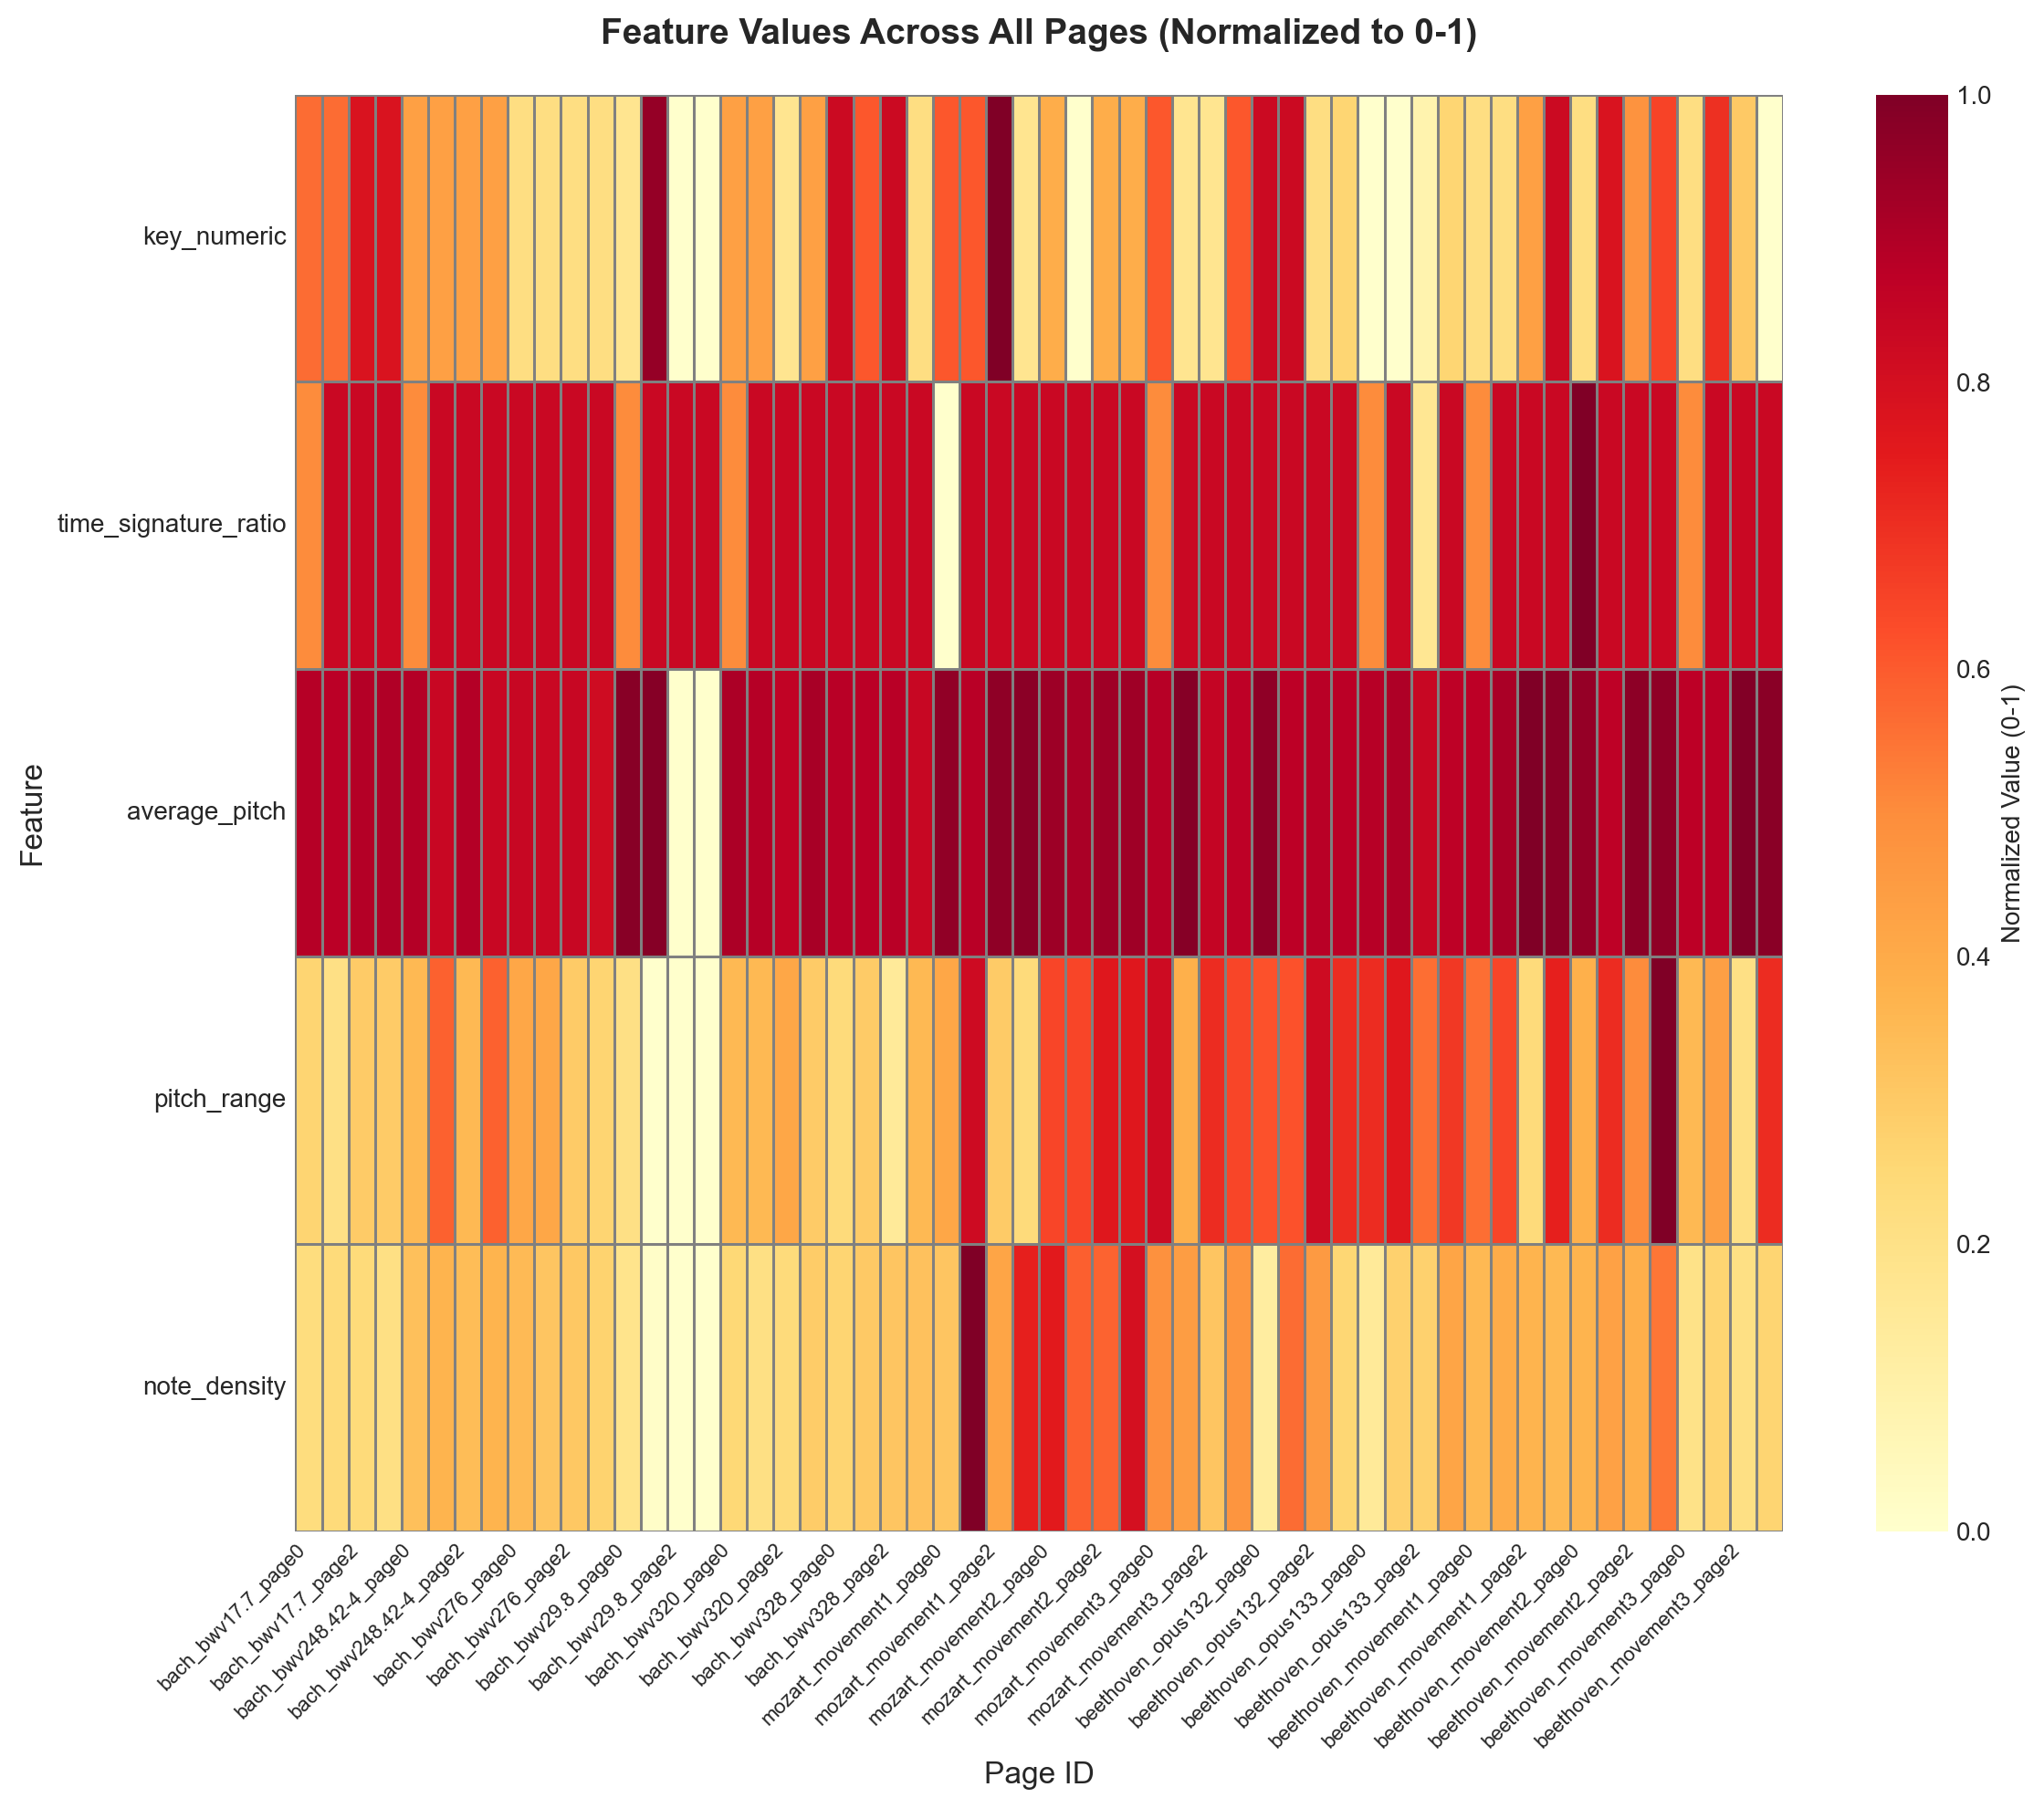

✓ Feature heatmap created

The heatmap shows normalized feature values (0-1 range) for 56 pages.
Warmer colors (red/orange) indicate higher values, cooler colors (yellow/white) indicate lower values.


In [14]:
# Normalize features to 0-1 range for visualization
from sklearn.preprocessing import MinMaxScaler

# Extract feature columns
feature_matrix = features_df[feature_cols].values

# Normalize each feature to 0-1 range
scaler = MinMaxScaler()
feature_matrix_normalized = scaler.fit_transform(feature_matrix)

# Create normalized DataFrame for visualization
features_normalized_df = pd.DataFrame(
    feature_matrix_normalized,
    columns=feature_cols,
    index=features_df['page_id']
)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    features_normalized_df.T,  # Transpose so features are rows
    cmap='YlOrRd',
    cbar_kws={'label': 'Normalized Value (0-1)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax,
    vmin=0,
    vmax=1
)

ax.set_xlabel('Page ID', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Values Across All Pages (Normalized to 0-1)', 
             fontsize=14, fontweight='bold', pad=20)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Feature heatmap created")
print(f"\nThe heatmap shows normalized feature values (0-1 range) for {len(features_df)} pages.")
print("Warmer colors (red/orange) indicate higher values, cooler colors (yellow/white) indicate lower values.")


## Feature Similarity Functions

Define how to compute similarity between two pages for each feature. Each similarity function returns a value between 0 (completely different) and 1 (identical).

The similarity functions will be used to compare pages in the optimization-based matching algorithm.

In [15]:
def key_similarity(key1, key2):
    """
    Compute similarity between two key signatures.
    
    Args:
        key1, key2: Key numeric values (0-11.5)
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |key1 - key2| / 6)
    Normalizes by 6 (half octave) to capture key relationships.
    """
    return max(0.0, 1.0 - abs(key1 - key2) / 6.0)


def time_sig_similarity(ts1, ts2):
    """
    Compute similarity between two time signatures.
    
    Args:
        ts1, ts2: Time signature ratios (e.g., 0.75 for 3/4)
        
    Returns:
        1.0 if exact match, 0.0 otherwise
        
    Binary similarity - time signatures either match or don't.
    """
    return 1.0 if abs(ts1 - ts2) < 1e-6 else 0.0


def average_pitch_similarity(pitch1, pitch2):
    """
    Compute similarity between average pitches.
    
    Args:
        pitch1, pitch2: Average MIDI pitch values
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |pitch1 - pitch2| / 24)
    Normalizes by 24 semitones (2 octaves), a typical vocal range.
    """
    return max(0.0, 1.0 - abs(pitch1 - pitch2) / 24.0)


def pitch_range_similarity(range1, range2):
    """
    Compute similarity between pitch ranges.
    
    Args:
        range1, range2: Pitch range values (max - min pitch)
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |range1 - range2| / 24)
    Normalizes by 24 semitones (2 octaves).
    """
    return max(0.0, 1.0 - abs(range1 - range2) / 24.0)


def note_density_similarity(density1, density2):
    """
    Compute similarity between note densities.
    
    Args:
        density1, density2: Note density values (notes per beat)
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |density1 - density2| / 5)
    Normalizes by 5, a typical range for note density variations.
    """
    return max(0.0, 1.0 - abs(density1 - density2) / 5.0)


print("✓ Individual similarity functions defined:")
print("  - key_similarity()")
print("  - time_sig_similarity()")
print("  - average_pitch_similarity()")
print("  - pitch_range_similarity()")
print("  - note_density_similarity()")

✓ Individual similarity functions defined:
  - key_similarity()
  - time_sig_similarity()
  - average_pitch_similarity()
  - pitch_range_similarity()
  - note_density_similarity()


### Combined Similarity Function

Create a function that computes all 5 feature similarities between two pages and returns them as a vector.

In [16]:
def compute_similarity_vector(page_features_1, page_features_2):
    """
    Compute similarity vector between two pages across all features.
    
    Args:
        page_features_1: Series or dict with features for page 1
        page_features_2: Series or dict with features for page 2
        
    Returns:
        numpy array of shape (5,) with similarity values for:
        [key, time_sig, avg_pitch, pitch_range, note_density]
        
    Each similarity value is between 0 (completely different) and 1 (identical).
    """
    similarities = np.array([
        key_similarity(
            page_features_1['key_numeric'], 
            page_features_2['key_numeric']
        ),
        time_sig_similarity(
            page_features_1['time_signature_ratio'], 
            page_features_2['time_signature_ratio']
        ),
        average_pitch_similarity(
            page_features_1['average_pitch'], 
            page_features_2['average_pitch']
        ),
        pitch_range_similarity(
            page_features_1['pitch_range'], 
            page_features_2['pitch_range']
        ),
        note_density_similarity(
            page_features_1['note_density'], 
            page_features_2['note_density']
        )
    ])
    
    return similarities


print("✓ Combined similarity function defined: compute_similarity_vector()")
print("  Returns numpy array with 5 similarity values (0-1 range)")

✓ Combined similarity function defined: compute_similarity_vector()
  Returns numpy array with 5 similarity values (0-1 range)


### Test Similarity Functions

Test the similarity functions on sample page pairs to verify they work correctly:
1. **Within-chorale comparison**: Two pages from the same chorale (should have high similarities)
2. **Between-chorale comparison**: Two pages from different chorales (should have lower similarities)

In [17]:
print("Testing Similarity Functions")
print("=" * 80)

# Get list of unique piece IDs
unique_pieces = features_df['piece_id'].unique()
print(f"Available pieces: {len(unique_pieces)}")
print(f"Sample: {list(unique_pieces[:3])}\n")

# Test 1: Compare two pages from the SAME piece
# Select first two pages from the first piece
piece_1_pages = features_df[features_df['piece_id'] == unique_pieces[0]]
page1 = piece_1_pages.iloc[0]
page2 = piece_1_pages.iloc[1]

print("Test 1: Within-Piece Similarity (Same Piece)")
print("-" * 80)
print(f"Page 1: {page1['page_id']}")
print(f"Page 2: {page2['page_id']}")
print(f"Piece: {page1['piece_id']} (Composer: {page1['composer']})")
print()

# Compute similarity
sim_within = compute_similarity_vector(page1, page2)

print("Feature values:")
print(f"  Page 1: key={page1['key_numeric']:.2f}, ts={page1['time_signature_ratio']:.2f}, "
      f"pitch={page1['average_pitch']:.2f}, range={page1['pitch_range']:.2f}, "
      f"density={page1['note_density']:.2f}")
print(f"  Page 2: key={page2['key_numeric']:.2f}, ts={page2['time_signature_ratio']:.2f}, "
      f"pitch={page2['average_pitch']:.2f}, range={page2['pitch_range']:.2f}, "
      f"density={page2['note_density']:.2f}")
print()

print("Similarity vector:")
feature_names = ['key', 'time_sig', 'avg_pitch', 'pitch_range', 'note_density']
for i, (name, sim_val) in enumerate(zip(feature_names, sim_within)):
    print(f"  {name:15s}: {sim_val:.3f}")
print(f"  {'Mean similarity':15s}: {sim_within.mean():.3f}")

print("\n" + "=" * 80)

# Test 2: Compare pages from DIFFERENT pieces
# Select first page from first piece and first page from second piece
if len(unique_pieces) >= 2:
    piece_2_pages = features_df[features_df['piece_id'] == unique_pieces[1]]
    page3 = piece_1_pages.iloc[0]
    page4 = piece_2_pages.iloc[0]
    
    print("\nTest 2: Between-Piece Similarity (Different Pieces)")
    print("-" * 80)
    print(f"Page 3: {page3['page_id']} (Piece: {page3['piece_id']}, Composer: {page3['composer']})")
    print(f"Page 4: {page4['page_id']} (Piece: {page4['piece_id']}, Composer: {page4['composer']})")
    print()
    
    # Compute similarity
    sim_between = compute_similarity_vector(page3, page4)
    
    print("Feature values:")
    print(f"  Page 3: key={page3['key_numeric']:.2f}, ts={page3['time_signature_ratio']:.2f}, "
          f"pitch={page3['average_pitch']:.2f}, range={page3['pitch_range']:.2f}, "
          f"density={page3['note_density']:.2f}")
    print(f"  Page 4: key={page4['key_numeric']:.2f}, ts={page4['time_signature_ratio']:.2f}, "
          f"pitch={page4['average_pitch']:.2f}, range={page4['pitch_range']:.2f}, "
          f"density={page4['note_density']:.2f}")
    print()
    
    print("Similarity vector:")
    for i, (name, sim_val) in enumerate(zip(feature_names, sim_between)):
        print(f"  {name:15s}: {sim_val:.3f}")
    print(f"  {'Mean similarity':15s}: {sim_between.mean():.3f}")
    
    print("\n" + "=" * 80)
    print("\nComparison:")
    print(f"  Within-piece mean similarity:  {sim_within.mean():.3f}")
    print(f"  Between-piece mean similarity: {sim_between.mean():.3f}")
    print(f"  Difference: {sim_within.mean() - sim_between.mean():.3f}")
    
    if sim_within.mean() > sim_between.mean():
        print("  ✓ Expected behavior: Pages from same piece are more similar")
    else:
        print("  ⚠ Unexpected: Between-piece similarity is higher")
else:
    print("\n⚠ Not enough pieces to test between-piece similarity")

print("\n" + "=" * 80)
print("✓ Similarity function testing complete!")

Testing Similarity Functions
Available pieces: 14
Sample: ['bach_bwv17.7', 'bach_bwv248.42-4', 'bach_bwv276']

Test 1: Within-Piece Similarity (Same Piece)
--------------------------------------------------------------------------------
Page 1: bach_bwv17.7_page0
Page 2: bach_bwv17.7_page1
Piece: bach_bwv17.7 (Composer: bach)

Feature values:
  Page 1: key=6.50, ts=0.75, pitch=70.19, range=9.00, density=0.73
  Page 2: key=6.50, ts=1.00, pitch=69.50, range=7.00, density=0.76

Similarity vector:
  key            : 1.000
  time_sig       : 0.000
  avg_pitch      : 0.971
  pitch_range    : 0.917
  note_density   : 0.993
  Mean similarity: 0.776


Test 2: Between-Piece Similarity (Different Pieces)
--------------------------------------------------------------------------------
Page 3: bach_bwv17.7_page0 (Piece: bach_bwv17.7, Composer: bach)
Page 4: bach_bwv248.42-4_page0 (Piece: bach_bwv248.42-4, Composer: bach)

Feature values:
  Page 3: key=6.50, ts=0.75, pitch=70.19, range=9.00, density

## Generate Training Pairs with Ground Truth Labels

Create a dataset of page pairs with labels for training and testing the optimization algorithm:
- **Matching pairs (label=1)**: Pages from the same piece (different pages)
- **Hard negative pairs (label=0)**: Pages from different pieces by the same composer
- **Easy negative pairs (label=0)**: Pages from different composers

This three-tiered approach creates a more challenging and realistic matching problem.
Each pair will have a computed similarity vector across all 5 features.

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

print("Generating Training Pairs with Multi-Composer Strategy")
print("=" * 80)

# Configuration
NUM_MATCHING_PAIRS = 20  # Same piece, different pages
NUM_HARD_NEGATIVE_PAIRS = 15  # Same composer, different pieces
NUM_EASY_NEGATIVE_PAIRS = 15  # Different composers
TOTAL_PAIRS = NUM_MATCHING_PAIRS + NUM_HARD_NEGATIVE_PAIRS + NUM_EASY_NEGATIVE_PAIRS

print(f"Target pair distribution:")
print(f"  • Matching pairs (label=1): {NUM_MATCHING_PAIRS}")
print(f"  • Hard negative pairs (label=0, same composer): {NUM_HARD_NEGATIVE_PAIRS}")
print(f"  • Easy negative pairs (label=0, different composer): {NUM_EASY_NEGATIVE_PAIRS}")
print(f"  • Total pairs: {TOTAL_PAIRS}")

# ===== Generate Matching Pairs (label = 1) =====
print(f"\n{'=' * 80}")
print(f"Step 1: Generating {NUM_MATCHING_PAIRS} matching pairs (same piece, different pages)")
print(f"{'=' * 80}")

matching_pairs = []
unique_pieces = features_df['piece_id'].unique()

# Calculate how many pairs per piece (approximately)
pairs_per_piece = NUM_MATCHING_PAIRS // len(unique_pieces)
extra_pairs = NUM_MATCHING_PAIRS % len(unique_pieces)

for i, piece_id in enumerate(unique_pieces):
    # Get all pages for this piece
    piece_pages = features_df[features_df['piece_id'] == piece_id]
    page_indices = piece_pages.index.tolist()
    
    # Determine number of pairs for this piece
    num_pairs_this_piece = pairs_per_piece + (1 if i < extra_pairs else 0)
    
    if len(page_indices) < 2:
        print(f"  ⚠ {piece_id}: Only {len(page_indices)} pages, skipping")
        continue
    
    # Generate diverse pairs (not just consecutive)
    from itertools import combinations
    all_possible_pairs = list(combinations(page_indices, 2))
    
    # Sample randomly from possible pairs
    num_pairs_to_sample = min(num_pairs_this_piece, len(all_possible_pairs))
    if num_pairs_to_sample > 0:
        sampled_pairs = np.random.choice(len(all_possible_pairs), size=num_pairs_to_sample, replace=False)
        
        for pair_idx in sampled_pairs:
            idx1, idx2 = all_possible_pairs[pair_idx]
            matching_pairs.append((idx1, idx2))
        
        composer = piece_pages.iloc[0]['composer']
        print(f"  ✓ {piece_id} ({composer}): Generated {num_pairs_to_sample} pairs from {len(page_indices)} pages")

print(f"\n✓ Generated {len(matching_pairs)} matching pairs")

# ===== Generate Hard Negative Pairs (label = 0, same composer) =====
print(f"\n{'=' * 80}")
print(f"Step 2: Generating {NUM_HARD_NEGATIVE_PAIRS} hard negative pairs (same composer, different pieces)")
print(f"{'=' * 80}")

hard_negative_pairs = []

# For each composer, generate pairs from different pieces
for composer_id in COMPOSERS.keys():
    composer_pieces = [p for p in unique_pieces if features_df[features_df['piece_id'] == p].iloc[0]['composer'] == composer_id]
    
    if len(composer_pieces) < 2:
        print(f"  ⚠ {composer_id}: Only {len(composer_pieces)} pieces, skipping hard negatives")
        continue
    
    # Calculate pairs for this composer (proportional to number of composers)
    num_pairs_this_composer = NUM_HARD_NEGATIVE_PAIRS // len(COMPOSERS)
    
    for _ in range(num_pairs_this_composer):
        # Select two different pieces from same composer
        piece_ids = np.random.choice(composer_pieces, size=2, replace=False)
        
        # Select random page from each piece
        page1_idx = features_df[features_df['piece_id'] == piece_ids[0]].sample(1).index[0]
        page2_idx = features_df[features_df['piece_id'] == piece_ids[1]].sample(1).index[0]
        
        hard_negative_pairs.append((page1_idx, page2_idx))
    
    print(f"  ✓ {COMPOSERS[composer_id]['name']}: Generated {num_pairs_this_composer} pairs from {len(composer_pieces)} pieces")

print(f"\n✓ Generated {len(hard_negative_pairs)} hard negative pairs")

# ===== Generate Easy Negative Pairs (label = 0, different composers) =====
print(f"\n{'=' * 80}")
print(f"Step 3: Generating {NUM_EASY_NEGATIVE_PAIRS} easy negative pairs (different composers)")
print(f"{'=' * 80}")

easy_negative_pairs = []
composer_pair_counts = {}

for _ in range(NUM_EASY_NEGATIVE_PAIRS):
    # Select two different composers
    composer_ids = np.random.choice(list(COMPOSERS.keys()), size=2, replace=False)
    composer_pair_key = tuple(sorted(composer_ids))
    composer_pair_counts[composer_pair_key] = composer_pair_counts.get(composer_pair_key, 0) + 1
    
    # Select random piece from each composer
    piece1_options = [p for p in unique_pieces if features_df[features_df['piece_id'] == p].iloc[0]['composer'] == composer_ids[0]]
    piece2_options = [p for p in unique_pieces if features_df[features_df['piece_id'] == p].iloc[0]['composer'] == composer_ids[1]]
    
    piece_id_1 = np.random.choice(piece1_options)
    piece_id_2 = np.random.choice(piece2_options)
    
    # Select random page from each piece
    page1_idx = features_df[features_df['piece_id'] == piece_id_1].sample(1).index[0]
    page2_idx = features_df[features_df['piece_id'] == piece_id_2].sample(1).index[0]
    
    easy_negative_pairs.append((page1_idx, page2_idx))

print(f"✓ Generated {len(easy_negative_pairs)} easy negative pairs")
print(f"  Composer pair distribution:")
for (c1, c2), count in sorted(composer_pair_counts.items()):
    print(f"    {COMPOSERS[c1]['name']} ↔ {COMPOSERS[c2]['name']}: {count} pairs")

print("\n" + "=" * 80)
print(f"Total pairs generated: {len(matching_pairs) + len(hard_negative_pairs) + len(easy_negative_pairs)}")
print(f"  • Matching (label=1): {len(matching_pairs)}")
print(f"  • Hard negatives (label=0): {len(hard_negative_pairs)}")
print(f"  • Easy negatives (label=0): {len(easy_negative_pairs)}")

Generating Training Pairs with Multi-Composer Strategy
Target pair distribution:
  • Matching pairs (label=1): 20
  • Hard negative pairs (label=0, same composer): 15
  • Easy negative pairs (label=0, different composer): 15
  • Total pairs: 50

Step 1: Generating 20 matching pairs (same piece, different pages)
  ✓ bach_bwv17.7 (bach): Generated 2 pairs from 4 pages
  ✓ bach_bwv248.42-4 (bach): Generated 2 pairs from 4 pages
  ✓ bach_bwv276 (bach): Generated 2 pairs from 4 pages
  ✓ bach_bwv29.8 (bach): Generated 2 pairs from 4 pages
  ✓ bach_bwv320 (bach): Generated 2 pairs from 4 pages
  ✓ bach_bwv328 (bach): Generated 2 pairs from 4 pages
  ✓ mozart_movement1 (mozart): Generated 1 pairs from 4 pages
  ✓ mozart_movement2 (mozart): Generated 1 pairs from 4 pages
  ✓ mozart_movement3 (mozart): Generated 1 pairs from 4 pages
  ✓ beethoven_opus132 (beethoven): Generated 1 pairs from 4 pages
  ✓ beethoven_opus133 (beethoven): Generated 1 pairs from 4 pages
  ✓ beethoven_movement1 (beethov

### Compute Similarity Vectors for All Pairs

For each pair, compute the 5-dimensional similarity vector using the previously defined functions.

In [19]:
print("Computing similarity vectors for all pairs...")
print("=" * 80)

# Prepare data for DataFrame
dataset_rows = []

# Process matching pairs (label = 1)
print(f"\nProcessing {len(matching_pairs)} matching pairs...")
for idx1, idx2 in matching_pairs:
    page1 = features_df.loc[idx1]
    page2 = features_df.loc[idx2]
    
    # Compute similarity vector
    sim_vector = compute_similarity_vector(page1, page2)
    
    # Create row for dataset
    row = {
        'page_id_1': page1['page_id'],
        'page_id_2': page2['page_id'],
        'piece_1': page1['piece_id'],
        'piece_2': page2['piece_id'],
        'composer_1': page1['composer'],
        'composer_2': page2['composer'],
        'pair_type': 'matching',
        'label': 1,  # Matching pair
        'sim_key': sim_vector[0],
        'sim_time_sig': sim_vector[1],
        'sim_avg_pitch': sim_vector[2],
        'sim_pitch_range': sim_vector[3],
        'sim_note_density': sim_vector[4]
    }
    dataset_rows.append(row)

print(f"✓ Processed {len(matching_pairs)} matching pairs")

# Process hard negative pairs (label = 0, same composer)
print(f"\nProcessing {len(hard_negative_pairs)} hard negative pairs...")
for idx1, idx2 in hard_negative_pairs:
    page1 = features_df.loc[idx1]
    page2 = features_df.loc[idx2]
    
    # Compute similarity vector
    sim_vector = compute_similarity_vector(page1, page2)
    
    # Create row for dataset
    row = {
        'page_id_1': page1['page_id'],
        'page_id_2': page2['page_id'],
        'piece_1': page1['piece_id'],
        'piece_2': page2['piece_id'],
        'composer_1': page1['composer'],
        'composer_2': page2['composer'],
        'pair_type': 'hard_negative',
        'label': 0,  # Non-matching pair
        'sim_key': sim_vector[0],
        'sim_time_sig': sim_vector[1],
        'sim_avg_pitch': sim_vector[2],
        'sim_pitch_range': sim_vector[3],
        'sim_note_density': sim_vector[4]
    }
    dataset_rows.append(row)

print(f"✓ Processed {len(hard_negative_pairs)} hard negative pairs")

# Process easy negative pairs (label = 0, different composers)
print(f"\nProcessing {len(easy_negative_pairs)} easy negative pairs...")
for idx1, idx2 in easy_negative_pairs:
    page1 = features_df.loc[idx1]
    page2 = features_df.loc[idx2]
    
    # Compute similarity vector
    sim_vector = compute_similarity_vector(page1, page2)
    
    # Create row for dataset
    row = {
        'page_id_1': page1['page_id'],
        'page_id_2': page2['page_id'],
        'piece_1': page1['piece_id'],
        'piece_2': page2['piece_id'],
        'composer_1': page1['composer'],
        'composer_2': page2['composer'],
        'pair_type': 'easy_negative',
        'label': 0,  # Non-matching pair
        'sim_key': sim_vector[0],
        'sim_time_sig': sim_vector[1],
        'sim_avg_pitch': sim_vector[2],
        'sim_pitch_range': sim_vector[3],
        'sim_note_density': sim_vector[4]
    }
    dataset_rows.append(row)

print(f"✓ Processed {len(easy_negative_pairs)} easy negative pairs")

# Create DataFrame
pairs_dataset = pd.DataFrame(dataset_rows)

print("\n" + "=" * 80)
print(f"Dataset created: {len(pairs_dataset)} total pairs")
print(f"  Matching pairs (label=1): {(pairs_dataset['label'] == 1).sum()}")
print(f"  Non-matching pairs (label=0): {(pairs_dataset['label'] == 0).sum()}")
print(f"\nBreakdown by pair type:")
print(f"  Matching: {(pairs_dataset['pair_type'] == 'matching').sum()}")
print(f"  Hard negatives (same composer): {(pairs_dataset['pair_type'] == 'hard_negative').sum()}")
print(f"  Easy negatives (diff composer): {(pairs_dataset['pair_type'] == 'easy_negative').sum()}")
print(f"\nDataset shape: {pairs_dataset.shape}")
print(f"Columns: {list(pairs_dataset.columns)}")

Computing similarity vectors for all pairs...

Processing 20 matching pairs...
✓ Processed 20 matching pairs

Processing 15 hard negative pairs...
✓ Processed 15 hard negative pairs

Processing 15 easy negative pairs...
✓ Processed 15 easy negative pairs

Dataset created: 50 total pairs
  Matching pairs (label=1): 20
  Non-matching pairs (label=0): 30

Breakdown by pair type:
  Matching: 20
  Hard negatives (same composer): 15
  Easy negatives (diff composer): 15

Dataset shape: (50, 13)
Columns: ['page_id_1', 'page_id_2', 'piece_1', 'piece_2', 'composer_1', 'composer_2', 'pair_type', 'label', 'sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']


### Train/Test Split

Split the dataset into training (70%) and testing (30%) sets, ensuring both splits have both matching and non-matching pairs.

In [20]:
from sklearn.model_selection import train_test_split

print("Creating Train/Test Split")
print("=" * 80)

# Configuration
TEST_SIZE = 0.3  # 30% for testing
RANDOM_STATE = 42

# Perform stratified split to ensure both labels are in both splits
train_data, test_data = train_test_split(
    pairs_dataset,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=pairs_dataset['label']  # Stratify by label to ensure balanced splits
)

print(f"\nSplit configuration:")
print(f"  Test size: {TEST_SIZE * 100:.0f}%")
print(f"  Random state: {RANDOM_STATE}")

print(f"\nTraining set:")
print(f"  Total pairs: {len(train_data)}")
print(f"  Matching pairs (label=1): {(train_data['label'] == 1).sum()}")
print(f"  Non-matching pairs (label=0): {(train_data['label'] == 0).sum()}")
print(f"  Balance: {(train_data['label'] == 1).sum() / len(train_data) * 100:.1f}% positive")

print(f"\nTest set:")
print(f"  Total pairs: {len(test_data)}")
print(f"  Matching pairs (label=1): {(test_data['label'] == 1).sum()}")
print(f"  Non-matching pairs (label=0): {(test_data['label'] == 0).sum()}")
print(f"  Balance: {(test_data['label'] == 1).sum() / len(test_data) * 100:.1f}% positive")

print("\n" + "=" * 80)
print("✓ Train/test split complete!")


Creating Train/Test Split

Split configuration:
  Test size: 30%
  Random state: 42

Training set:
  Total pairs: 35
  Matching pairs (label=1): 14
  Non-matching pairs (label=0): 21
  Balance: 40.0% positive

Test set:
  Total pairs: 15
  Matching pairs (label=1): 6
  Non-matching pairs (label=0): 9
  Balance: 40.0% positive

✓ Train/test split complete!


### Dataset Visualization and Analysis

Visualize sample pairs and analyze feature correlations.

In [21]:
print("Sample Pairs from Training Set")
print("=" * 80)

# Show sample pairs from each type
# Get 2 matching, 2 hard negative, and 1 easy negative
matching_samples = train_data[train_data['pair_type'] == 'matching'].head(2)
hard_neg_samples = train_data[train_data['pair_type'] == 'hard_negative'].head(2)
easy_neg_samples = train_data[train_data['pair_type'] == 'easy_negative'].head(1)
sample_pairs = pd.concat([matching_samples, hard_neg_samples, easy_neg_samples])

# Define feature columns for display
sim_cols = ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']

print("\nShowing 5 sample pairs (2 matching, 2 hard neg, 1 easy neg):\n")

for idx, row in sample_pairs.iterrows():
    label_str = "MATCH" if row['label'] == 1 else "NON-MATCH"
    pair_type = row['pair_type'].replace('_', ' ').title()
    print(f"Pair: {row['page_id_1']} <-> {row['page_id_2']}")
    print(f"  Label: {label_str} ({pair_type})")
    print(f"  Pieces: {row['piece_1']} <-> {row['piece_2']}")
    print(f"  Composers: {row['composer_1']} <-> {row['composer_2']}")
    print(f"  Similarity vector:")
    for col in sim_cols:
        print(f"    {col:20s}: {row[col]:.3f}")
    print()

print("=" * 80)

Sample Pairs from Training Set

Showing 5 sample pairs (2 matching, 2 hard neg, 1 easy neg):

Pair: bach_bwv276_page0 <-> bach_bwv276_page2
  Label: MATCH (Matching)
  Pieces: bach_bwv276 <-> bach_bwv276
  Composers: bach <-> bach
  Similarity vector:
    sim_key             : 1.000
    sim_time_sig        : 1.000
    sim_avg_pitch       : 0.993
    sim_pitch_range     : 0.833
    sim_note_density    : 0.972

Pair: beethoven_movement3_page1 <-> beethoven_movement3_page3
  Label: MATCH (Matching)
  Pieces: beethoven_movement3 <-> beethoven_movement3
  Composers: beethoven <-> beethoven
  Similarity vector:
    sim_key             : 0.000
    sim_time_sig        : 1.000
    sim_avg_pitch       : 0.669
    sim_pitch_range     : 0.625
    sim_note_density    : 1.000

Pair: bach_bwv248.42-4_page3 <-> bach_bwv320_page1
  Label: NON-MATCH (Hard Negative)
  Pieces: bach_bwv248.42-4 <-> bach_bwv320
  Composers: bach <-> bach
  Similarity vector:
    sim_key             : 1.000
    sim_time_sig 


Feature Correlation Analysis

Correlation Matrix:
                   sim_key  sim_time_sig  sim_avg_pitch  sim_pitch_range  sim_note_density
sim_key           1.000000      0.037880       0.039392         0.051436         -0.033375
sim_time_sig      0.037880      1.000000       0.028920         0.077444          0.052793
sim_avg_pitch     0.039392      0.028920       1.000000         0.254283          0.026968
sim_pitch_range   0.051436      0.077444       0.254283         1.000000          0.270516
sim_note_density -0.033375      0.052793       0.026968         0.270516          1.000000

Interpretation:
  Values close to 1 or -1 indicate high correlation (redundant features)
  Values close to 0 indicate low correlation (independent features)


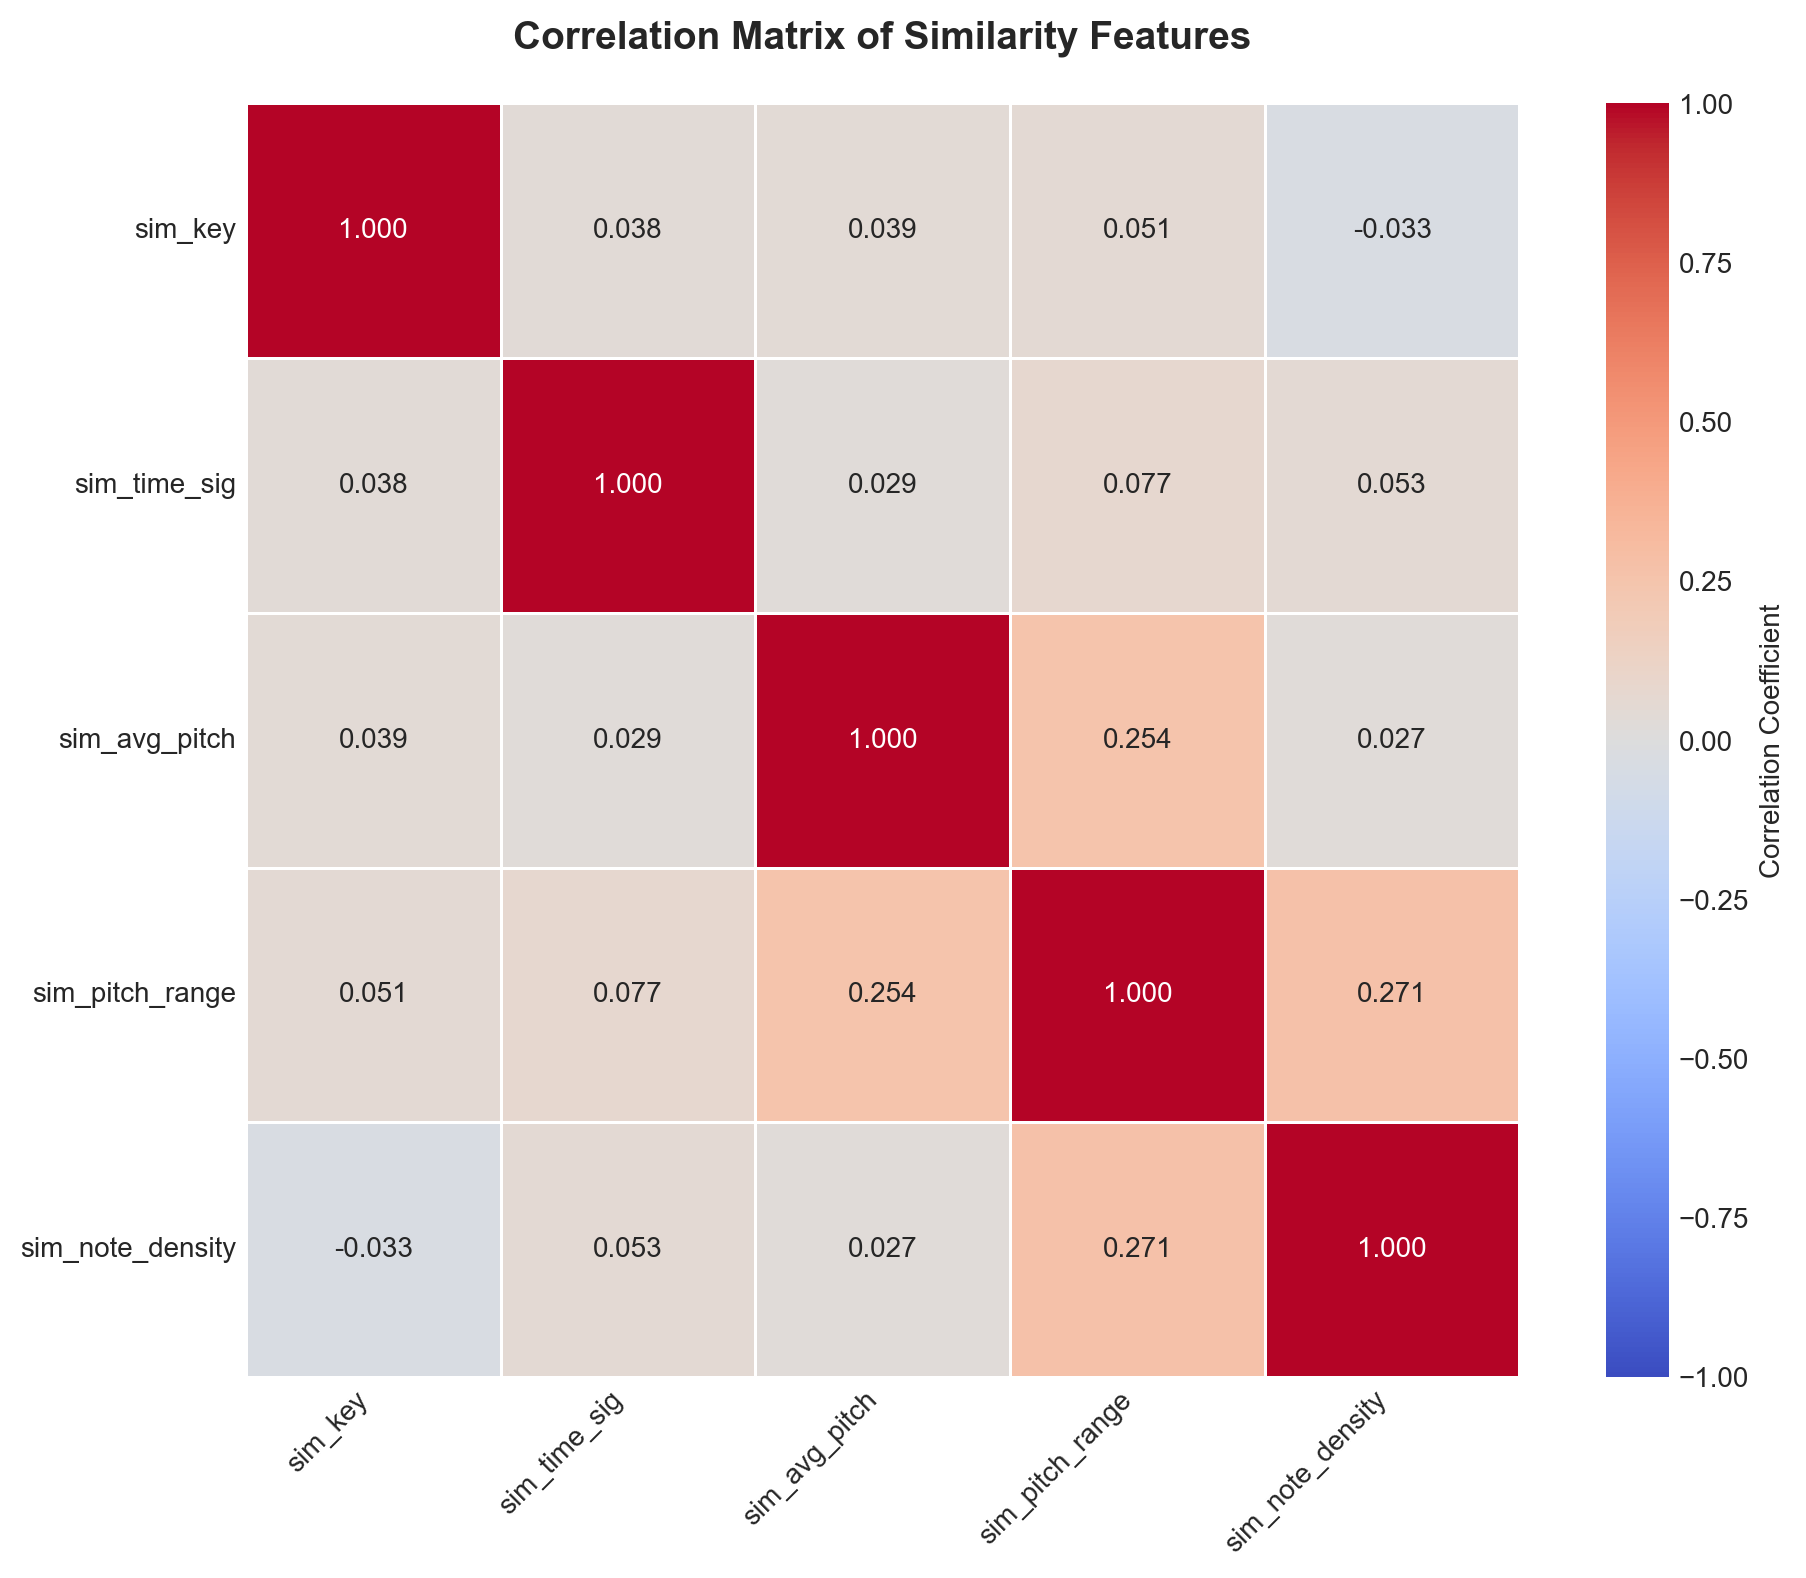


✓ Feature correlation analysis complete!


In [22]:
print("\nFeature Correlation Analysis")
print("=" * 80)

# Extract similarity features
sim_features = pairs_dataset[sim_cols]

# Compute correlation matrix
correlation_matrix = sim_features.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.to_string())

print("\n" + "=" * 80)
print("Interpretation:")
print("  Values close to 1 or -1 indicate high correlation (redundant features)")
print("  Values close to 0 indicate low correlation (independent features)")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=ax
)

ax.set_title('Correlation Matrix of Similarity Features', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n✓ Feature correlation analysis complete!")


### Summary Statistics

Display summary statistics for similarity features grouped by label.

In [23]:
print("Summary Statistics by Label")
print("=" * 80)

# Group by label and compute statistics
print("\nMatching Pairs (label=1):")
print("-" * 80)
matching_stats = pairs_dataset[pairs_dataset['label'] == 1][sim_cols].describe()
print(matching_stats.to_string())

print("\n\nNon-Matching Pairs (label=0):")
print("-" * 80)
non_matching_stats = pairs_dataset[pairs_dataset['label'] == 0][sim_cols].describe()
print(non_matching_stats.to_string())

print("\n\nBreakdown by Pair Type:")
print("-" * 80)
for pair_type in ['matching', 'hard_negative', 'easy_negative']:
    subset = pairs_dataset[pairs_dataset['pair_type'] == pair_type]
    if len(subset) > 0:
        print(f"\n{pair_type.replace('_', ' ').title()} pairs ({len(subset)} pairs):")
        mean_sims = subset[sim_cols].mean()
        for col in sim_cols:
            print(f"  {col:20s}: {mean_sims[col]:.3f}")

print("\n\nMean Differences (Matching - Non-Matching):")
print("-" * 80)
mean_matching = pairs_dataset[pairs_dataset['label'] == 1][sim_cols].mean()
mean_non_matching = pairs_dataset[pairs_dataset['label'] == 0][sim_cols].mean()
mean_diff = mean_matching - mean_non_matching

for col in sim_cols:
    print(f"  {col:20s}: {mean_diff[col]:+.3f}")
    if mean_diff[col] > 0:
        print(f"    → Matching pairs have higher {col.replace('sim_', '')} similarity")
    else:
        print(f"    → Non-matching pairs have higher {col.replace('sim_', '')} similarity")

print("\n" + "=" * 80)
print("✓ Dataset preparation complete!")
print(f"\nFinal dataset summary:")
print(f"  Total pairs: {len(pairs_dataset)}")
print(f"  Training pairs: {len(train_data)} (70%)")
print(f"  Testing pairs: {len(test_data)} (30%)")
print(f"  Features per pair: {len(sim_cols)}")
print(f"\nComposer distribution in data:")
for composer_id in sorted(COMPOSERS.keys()):
    composer_name = COMPOSERS[composer_id]['name']
    num_pages = (features_df['composer'] == composer_id).sum()
    num_pieces = len([p for p in features_df['piece_id'].unique() if features_df[features_df['piece_id'] == p].iloc[0]['composer'] == composer_id])
    print(f"  {composer_name:12s}: {num_pieces} pieces, {num_pages} pages")

Summary Statistics by Label

Matching Pairs (label=1):
--------------------------------------------------------------------------------
         sim_key  sim_time_sig  sim_avg_pitch  sim_pitch_range  sim_note_density
count  20.000000     20.000000      20.000000        20.000000         20.000000
mean    0.541667      0.600000       0.863240         0.739583          0.939134
std     0.428772      0.502625       0.120533         0.198622          0.100994
min     0.000000      0.000000       0.655836         0.291667          0.566667
25%     0.125000      0.000000       0.794618         0.666667          0.947726
50%     0.541667      1.000000       0.887462         0.750000          0.973707
75%     1.000000      1.000000       0.972535         0.854167          0.991964
max     1.000000      1.000000       1.000000         1.000000          1.000000


Non-Matching Pairs (label=0):
--------------------------------------------------------------------------------
         sim_key  sim_

## Save Processed Data for Optimization Notebook

Save all processed data to files for use in the next notebook (optimization and weight learning).

In [25]:
import json
import os
from pathlib import Path

print("Saving Processed Data")
print("=" * 80)

# Create data directory if it doesn't exist
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

# Define file paths
features_file = data_dir / 'sheet_music_features.csv'
train_file = data_dir / 'train_pairs.csv'
test_file = data_dir / 'test_pairs.csv'
metadata_file = data_dir / 'data_metadata.json'

# ===== 1. Save Features DataFrame =====
print("\n1. Saving features DataFrame...")
features_df.to_csv(features_file, index=False)
print(f"   ✓ Saved to: {features_file}")
print(f"   Size: {os.path.getsize(features_file) / 1024:.2f} KB")
print(f"   Rows: {len(features_df)}, Columns: {len(features_df.columns)}")

# ===== 2. Save Training Pairs =====
print("\n2. Saving training pairs...")
train_data.to_csv(train_file, index=False)
print(f"   ✓ Saved to: {train_file}")
print(f"   Size: {os.path.getsize(train_file) / 1024:.2f} KB")
print(f"   Rows: {len(train_data)}, Columns: {len(train_data.columns)}")

# ===== 3. Save Test Pairs =====
print("\n3. Saving test pairs...")
test_data.to_csv(test_file, index=False)
print(f"   ✓ Saved to: {test_file}")
print(f"   Size: {os.path.getsize(test_file) / 1024:.2f} KB")
print(f"   Rows: {len(test_data)}, Columns: {len(test_data.columns)}")

# ===== 4. Save Metadata =====
print("\n4. Saving metadata...")

# Get composer statistics
composer_stats = {}
for composer_id, composer_info in COMPOSERS.items():
    num_pieces = len([p for p in features_df['piece_id'].unique() if features_df[features_df['piece_id'] == p].iloc[0]['composer'] == composer_id])
    num_pages = (features_df['composer'] == composer_id).sum()
    composer_stats[composer_id] = {
        'name': composer_info['name'],
        'era': composer_info['era'],
        'pieces': int(num_pieces),
        'pages': int(num_pages)
    }

metadata = {
    'dataset_info': {
        'total_composers': len(COMPOSERS),
        'total_pieces': len(pieces_data),
        'total_pages': len(pages_df),
        'measures_per_page': MEASURES_PER_PAGE,
        'pages_per_piece': TARGET_PAGES_PER_PIECE,
        'composers': composer_stats,
        'piece_ids': list(pieces_data.keys())
    },
    'features': {
        'count': len(feature_cols),
        'names': feature_cols,
        'description': {
            'key_numeric': 'Key signature (0-11 pitch class, +0.5 for minor)',
            'time_signature_ratio': 'Time signature as decimal (e.g., 3/4 = 0.75)',
            'average_pitch': 'Mean MIDI pitch number',
            'pitch_range': 'Range of pitches (max - min) in semitones',
            'note_density': 'Notes per beat (rhythmic activity)'
        }
    },
    'similarity_features': {
        'count': len(sim_cols),
        'names': sim_cols,
        'range': [0.0, 1.0],
        'description': '0 = completely different, 1 = identical'
    },
    'pairs': {
        'total_pairs': len(pairs_dataset),
        'matching_pairs': int((pairs_dataset['label'] == 1).sum()),
        'hard_negative_pairs': int((pairs_dataset['pair_type'] == 'hard_negative').sum()),
        'easy_negative_pairs': int((pairs_dataset['pair_type'] == 'easy_negative').sum()),
        'pair_type_description': {
            'matching': 'Same piece, different pages (label=1)',
            'hard_negative': 'Same composer, different pieces (label=0)',
            'easy_negative': 'Different composers (label=0)'
        }
    },
    'train_test_split': {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'train_pairs': len(train_data),
        'test_pairs': len(test_data),
        'train_positive': int((train_data['label'] == 1).sum()),
        'train_negative': int((train_data['label'] == 0).sum()),
        'test_positive': int((test_data['label'] == 1).sum()),
        'test_negative': int((test_data['label'] == 0).sum())
    },
    'statistics': {
        'feature_stats': {
            col: {
                'mean': float(features_df[col].mean()),
                'std': float(features_df[col].std()),
                'min': float(features_df[col].min()),
                'max': float(features_df[col].max())
            }
            for col in feature_cols
        },
        'similarity_stats': {
            'matching': {
                col: float(pairs_dataset[pairs_dataset['label'] == 1][col].mean())
                for col in sim_cols
            },
            'hard_negative': {
                col: float(pairs_dataset[pairs_dataset['pair_type'] == 'hard_negative'][col].mean())
                for col in sim_cols
            },
            'easy_negative': {
                col: float(pairs_dataset[pairs_dataset['pair_type'] == 'easy_negative'][col].mean())
                for col in sim_cols
            }
        }
    }
}

with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"   ✓ Saved to: {metadata_file}")
print(f"   Size: {os.path.getsize(metadata_file) / 1024:.2f} KB")

print("\n" + "=" * 80)
print("✓ All data saved successfully!")
print(f"\nSaved files:")
print(f"  • {features_file.name} - Feature data for all pages (with composer column)")
print(f"  • {train_file.name} - Training pairs with similarity vectors and pair types")
print(f"  • {test_file.name} - Test pairs with similarity vectors and pair types")
print(f"  • {metadata_file.name} - Dataset metadata and statistics")

Saving Processed Data

1. Saving features DataFrame...
   ✓ Saved to: ../data/sheet_music_features.csv
   Size: 4.81 KB
   Rows: 56, Columns: 8

2. Saving training pairs...
   ✓ Saved to: ../data/train_pairs.csv
   Size: 5.75 KB
   Rows: 35, Columns: 13

3. Saving test pairs...
   ✓ Saved to: ../data/test_pairs.csv
   Size: 2.64 KB
   Rows: 15, Columns: 13

4. Saving metadata...
   ✓ Saved to: ../data/data_metadata.json
   Size: 3.79 KB

✓ All data saved successfully!

Saved files:
  • sheet_music_features.csv - Feature data for all pages (with composer column)
  • train_pairs.csv - Training pairs with similarity vectors and pair types
  • test_pairs.csv - Test pairs with similarity vectors and pair types
  • data_metadata.json - Dataset metadata and statistics


### Data Files Summary

This notebook has created and saved the following data files for use in the optimization notebook:

#### 1. `sheet_music_features.csv`
Contains extracted musical features for all pages in the dataset.

**Schema:**
- `page_id` (string): Unique identifier for each page (e.g., "bach_bwv276_page0")
- `piece_id` (string): Identifier of the source piece (e.g., "bach_bwv276")
- `composer` (string): Composer identifier ("bach", "mozart", or "beethoven")
- `key_numeric` (float): Key signature encoded as 0-11.5 (pitch class + 0.5 for minor)
- `time_signature_ratio` (float): Time signature as decimal (e.g., 0.75 for 3/4)
- `average_pitch` (float): Mean MIDI pitch number
- `pitch_range` (float): Range of pitches in semitones
- `note_density` (float): Notes per beat

**Usage in next notebook:**
```python
features_df = pd.read_csv('../data/sheet_music_features.csv')
```

---

#### 2. `train_pairs.csv`
Training pairs with computed similarity vectors and ground truth labels.

**Schema:**
- `page_id_1`, `page_id_2` (string): Page identifiers for the pair
- `piece_1`, `piece_2` (string): Source piece identifiers
- `composer_1`, `composer_2` (string): Composer identifiers
- `pair_type` (string): Type of pair ("matching", "hard_negative", "easy_negative")
- `label` (int): 1 = matching (same piece), 0 = non-matching
- `sim_key` (float): Key similarity (0-1)
- `sim_time_sig` (float): Time signature similarity (0-1)
- `sim_avg_pitch` (float): Average pitch similarity (0-1)
- `sim_pitch_range` (float): Pitch range similarity (0-1)
- `sim_note_density` (float): Note density similarity (0-1)

**Pair Types:**
- **matching**: Same piece, different pages (label=1) - Tests if model can match pages from the same piece
- **hard_negative**: Same composer, different pieces (label=0) - Tests if model can distinguish between pieces by the same composer
- **easy_negative**: Different composers (label=0) - Should be easier to distinguish

**Usage in next notebook:**
```python
train_data = pd.read_csv('../data/train_pairs.csv')
X_train = train_data[['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']].values
y_train = train_data['label'].values
```

---

#### 3. `test_pairs.csv`
Test pairs with computed similarity vectors and ground truth labels (same schema as `train_pairs.csv`).

**Usage in next notebook:**
```python
test_data = pd.read_csv('../data/test_pairs.csv')
X_test = test_data[['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']].values
y_test = test_data['label'].values
```

---

#### 4. `data_metadata.json`
Comprehensive metadata including dataset statistics, feature descriptions, composer information, and split information.

**Usage in next notebook:**
```python
import json
with open('../data/data_metadata.json', 'r') as f:
    metadata = json.load(f)
print(f"Total composers: {metadata['dataset_info']['total_composers']}")
print(f"Total pieces: {metadata['dataset_info']['total_pieces']}")
print(f"Total pages: {metadata['dataset_info']['total_pages']}")
```

---

### Next Steps

Proceed to **Notebook 2: Optimization and Weight Learning** where you will:
1. Load the processed data files
2. Define a weighted similarity function
3. Use cvxpy to learn optimal feature weights through constrained optimization
4. Evaluate performance on the test set
5. Visualize learned weights and matching performance
6. Analyze how well the model distinguishes between matching, hard negative, and easy negative pairs